In [66]:
import pandas as pd
import numpy as np
import mglearn
import string
import spacy
import time
import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import tweepy
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    assert tf.config.experimental.get_memory_growth(physical_devices[0])
except:
    print("# Invalid device or cannot modify virtual devices once initialized.")
    pass
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding,  Bidirectional,Dense,LSTM

# Data Collection

Connecting to the Tweepy API

In [2]:
auth = tweepy.OAuthHandler('9tpKa7Rs0azYhUUZQ9t13zZbR', 'NJvdMLo901KiycSjlz1NlshQaM8iJmRLfHCXZhZXgUzwy2cl4y')
auth.set_access_token("1070877312604954625-91M4PyNC72QYws3lIm90mj5yIjElVU", "EpARpeIQECJDEWRe2WfWg239FQaHoWZa4xFreDMTm84Zf")
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

This retrieves All available tweets of a given query term

In [3]:
def CollectTweets(query):
    tweets=[]
    for tweet in tweepy.Cursor(api.search,tweet_mode="extended",q=query, lang="en").items():
        tweetText="String Error Did Not Find String."
        try: tweetText=(tweet.extended_tweet["full_text"])
        except AttributeError:
            try: tweetText=(tweet.full_text)
            except AttributeError: tweetText=(tweet.text)
        T= { "query"            :query,
                "id"              :str(tweet.id_str),
                "Text"        :tweetText}
        tweets.append(T)
    return pd.DataFrame(tweets)

Creates a tweet dataframe or loads it from disk if it already exists

In [4]:
try:
    tweetDF=pd.read_csv("CollectedTweets.csv")
    print("Reading CSV")
except:
    print("Creating New Tweets Dataframe")
    tweetDF=pd.DataFrame(columns=["query","id","Text"])

Reading CSV


Queries twitter for more tweets related to our query string, drops the duplicated tweets and saves it to disk

In [5]:
query="#covid-19 OR #covid_19 OR #covid19 OR #covid OR covid OR covid19 OR covid_19 OR covid-19 AND online AND classes"

In [6]:
tweetDF=tweetDF.append(CollectTweets(query), ignore_index = True).drop_duplicates(subset=['Text'])
tweetDF.to_csv("CollectedTweets.csv",index=False)
print("Retweets:",tweetDF["Text"].str.contains("RT ").sum())

Retweets: 426


# Data Labelling & Text Analytics Pipeline on Tweets:: 

apply a text analytics procedure of your choice. Always outline and justify your methodology .
1. Create a text analytics pipeline for text processing, representation, classification and evaluation.
2. Text processing techniques could include: tokenization, stemming, normalization and stopword/
punctuation removal, etc.
3. Representation and feature extraction can include using n-gram features vs. unigram features;
Vector space representation (binary, frequency count & tf-idf).
4. Compare the performance of the classifiers based on precision /recall.


Creating a tweet cleaning preprocessor object

In [7]:
punctuations=set(string.punctuation)
trans=str.maketrans('','',string.punctuation)
stopwordset=[w.translate(trans) for w in stopwords.words('english')]

In [8]:
from nltk.corpus import stopwords
class processer():
    def __init__(self,stemmer=None,tokenize=False,stopword=True, lower=True,links=True,retweets=True, users=True, hashtags=True, specialChars=True, nums=True, shortenBegin=True,repeats=True):
        if stopword: self.stopwordset=[word.translate(trans) for word in stopwords.words('english')]#Optimization
        self.regex=r"^"
        self.lower=lower
        self.stemmer=stemmer
        self.stopword=stopword
        self.tokenize=tokenize
        if links:        self.regex=self.regex+r"|(((((https?)?:\/\/)(www\.)?|www\.))([a-z0-9.]+)(\.[a-z]{2,4})(\.[a-z]{1,2})?([^?\s]+(\?((\w+)(=[^&\s]+)?&?)+)?)?)"
        if retweets:     self.regex=self.regex+r"|(RT \@[a-zA-Z0-9_.]*: )"
        if users:        self.regex=self.regex+r"|(\@[a-zA-Z0-9_.]* )"
        if hashtags:     self.regex=self.regex+r"|(\#[a-zA-Z0-9_%]*)"
        if specialChars: self.regex=self.regex+r"|([^\ 0-9a-zA-Z]+)"
        if nums:         self.regex=self.regex+r"|([0-9]*)"
        self.shortenBegin=shortenBegin
        self.repeats=repeats
    def stopW(self,sentence):
        sentence=sentence.split()
        temp=[]
        for word in sentence:
            if word not in self.stopwordset:
                if self.stemmer is not None: word=self.stemmer(word)
                temp.append(word)
        if self.tokenize: return temp
        return " ".join(temp)
        return [word for word in sentence.split() not in self.stopwordset]
    def process(self, sentence):
        if self.lower: sentence= sentence.lower()
        sentence = re.sub(self.regex,"",sentence)
        if self.shortenBegin: sentence = re.sub(r" (.)\1{1,}",r" \1",sentence)
        if self.repeats: sentence = re.sub(r"(.)\1{2,}",r"\1\1",sentence)
        if self.stopword: sentence= self.stopW(sentence)
        return sentence

Setup the steps you want to apply here

In [9]:
lemmatizer = WordNetLemmatizer() 
p=processer(stemmer=lemmatizer.lemmatize,tokenize=False,stopword=True, lower=True,
 links=True, retweets=True, users=True, hashtags=True, 
 specialChars=True, nums=True, shortenBegin=True,repeats=True)

Pre-apply it to the dataframe to avoid applying it to all the models 

Apply preprocessing to my collected tweets

In [10]:
tweetDF["Text_processed"]=tweetDF["Text"].apply(p.process)#preprocess text
#obtain sentiment of the preprocessed text using textblob
tweetDF["Sentiment"]=(tweetDF["Text_processed"].apply(TextBlob)).apply(lambda x: x.sentiment[0])
tweetDF=tweetDF.drop_duplicates(subset=['Text_processed'])#Drop duplicated tweets
tweetDF=tweetDF.sort_values(by="Sentiment")#sort by sentiment
#obtain binary categorical values instead of descrete sentiment values -1,0,1
tweetDF["SentimentB"]=tweetDF["Sentiment"].apply(np.sign)

In [11]:
# for x in range(10): print( tweetDF[tweetDF["Sentiment"]>0][["Text","Sentiment"]].values)
# for x in range(10): print( tweetDF[(tweetDF["Sentiment"]<0)][["Text","Sentiment"]].values)
# for x in range(10): print( tweetDF[(tweetDF["Sentiment"]==0)][["Text","Sentiment"]].values)

# Evaluating Models

Making a train and test split of collected labelled tweets

In [59]:
tweetDF=tweetDF.sample(frac=1)
trainX,testX,trainY,testY=train_test_split(tweetDF['Text_processed'], tweetDF[["SentimentB"]],test_size=0.2,shuffle=True)
print(len(tweetDF),len(trainX),len(testX))

1516 1212 304


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


              precision    recall  f1-score   support

        -1.0       0.86      0.42      0.56        88
         0.0       0.67      0.50      0.57        94
         1.0       0.54      0.84      0.66       122

    accuracy                           0.62       304
   macro avg       0.69      0.59      0.60       304
weighted avg       0.67      0.62      0.60       304



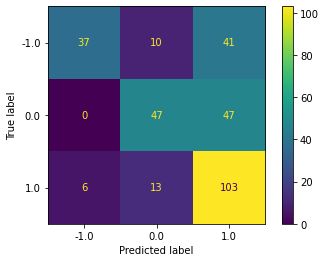

In [60]:
lrModel = Pipeline([
    ('bow', CountVectorizer(preprocessor=p.process, ngram_range=(1,2),analyzer="word",)),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression(verbose=1)),
])
lrModel.fit(trainX,trainY)
predictions=lrModel.predict(testX)
plot_confusion_matrix(lrModel,testX,testY)
print(classification_report(testY,predictions))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

        -1.0       0.88      0.33      0.48        88
         0.0       0.68      0.36      0.47        94
         1.0       0.52      0.94      0.67       122

    accuracy                           0.59       304
   macro avg       0.69      0.54      0.54       304
weighted avg       0.67      0.59      0.55       304



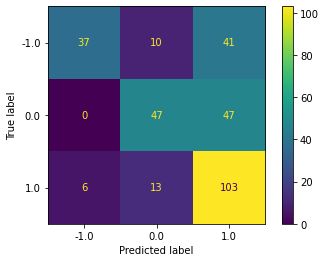

In [61]:
nbModel = Pipeline([
    ('bow', CountVectorizer(preprocessor=p.process, ngram_range=(1,2),analyzer="word",)),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', MultinomialNB()),  
])
nbModel.fit(trainX,trainY)
predictions=nbModel.predict(testX)
plot_confusion_matrix(lrModel,testX,testY)
print(classification_report(testY,predictions))

Epoch 1/20
41/41 [==============================] - 10s 14ms/step - loss: 1.0957 - categorical_accuracy: 0.3742
Epoch 2/20
41/41 [==============================] - 1s 14ms/step - loss: 1.0506 - categorical_accuracy: 0.4724
Epoch 3/20
41/41 [==============================] - 1s 14ms/step - loss: 0.6553 - categorical_accuracy: 0.7325
Epoch 4/20
41/41 [==============================] - 1s 14ms/step - loss: 0.1273 - categorical_accuracy: 0.9871
Epoch 5/20
41/41 [==============================] - 1s 14ms/step - loss: 0.0363 - categorical_accuracy: 0.9931
Epoch 6/20
41/41 [==============================] - 1s 14ms/step - loss: 0.0246 - categorical_accuracy: 0.9984
Epoch 7/20
41/41 [==============================] - 1s 14ms/step - loss: 0.0124 - categorical_accuracy: 0.9989
              precision    recall  f1-score   support

        -1.0       0.81      0.39      0.52        88
         0.0       0.85      0.48      0.61        94
         1.0       0.54      0.93      0.68       122

    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


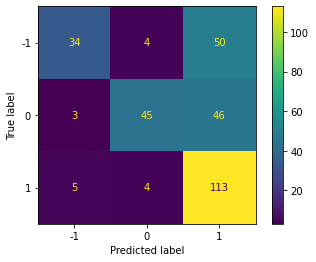

In [62]:
callbacks=[EarlyStopping(monitor='categorical_accuracy', min_delta=0, patience=1)]
def BiLSTM_model(dataset, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,hidden=16):
    vec_layer = TextVectorization(
        standardize=None, 
        output_mode=mode,    
        ngrams=ngram,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(dataset)
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(Bidirectional(LSTM(embedding_dim)))
    M.add(Dense(hidden, activation='relu'))
    M.add(Dense(3, activation='softmax'))    
    M.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["categorical_accuracy"])  
    return M
model =BiLSTM_model(trainX.values, ngram=2)
model.fit(trainX,tf.keras.utils.to_categorical(trainY,3) ,epochs=20,batch_size=30,callbacks=callbacks)
pp=pd.DataFrame(model.predict(testX)).apply(np.argmax,axis=1)
print(classification_report(testY,pp.map({0:0,1:1,2:-1})))
ConfusionMatrixDisplay(confusion_matrix(testY,pp.map({0:0,1:1,2:-1})),[-1,0,1]).plot()

<AxesSubplot:>

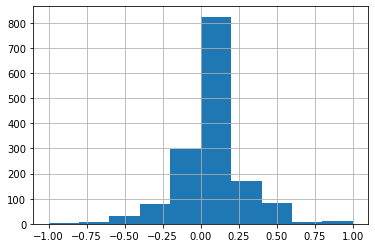

In [63]:
tweetDF["Sentiment"].hist(bins=10)

In [64]:
from sklearn.decomposition import LatentDirichletAllocation 

lda = LatentDirichletAllocation(n_components=100, learning_method="batch",max_iter=25, random_state=0)
vect = CountVectorizer(max_features=10000, max_df=0.2)
X = vect.fit_transform(tweetDF["Text"])
document_topics = lda.fit_transform(X)
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=range(100), feature_names=feature_names,sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
that          cases         with          year          have          
have          as            please        ago           that          
no            many          schools       one           they          
it            be            as            was           so            
with          ktrtrs        about         today         during        
has           officials     shut          it            onlin         
still         kindly        down          all           model         
due           on            would         my            on            
at            this          more          on            at            
out           sabithaindratrsour           break         not           


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
sch

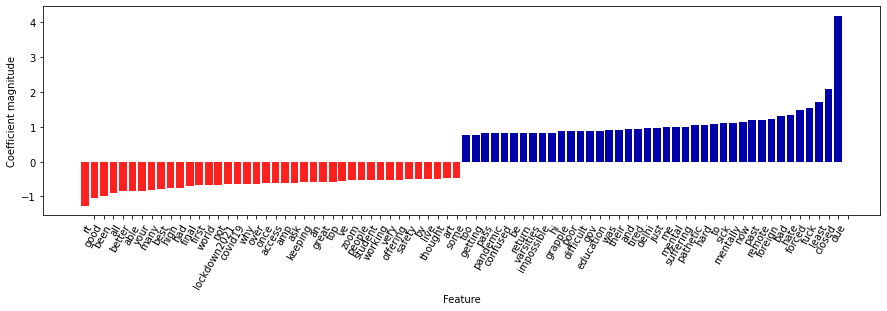

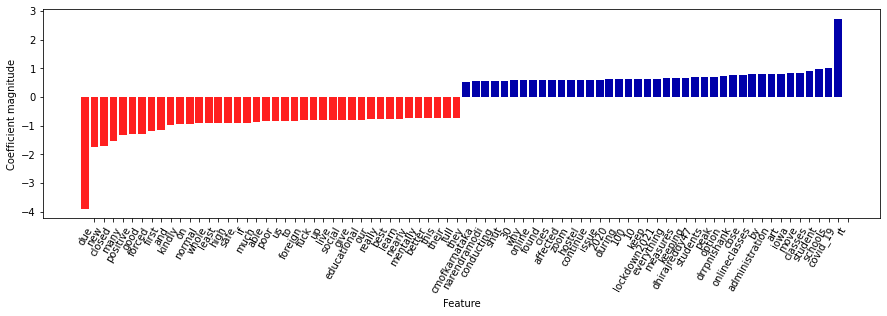

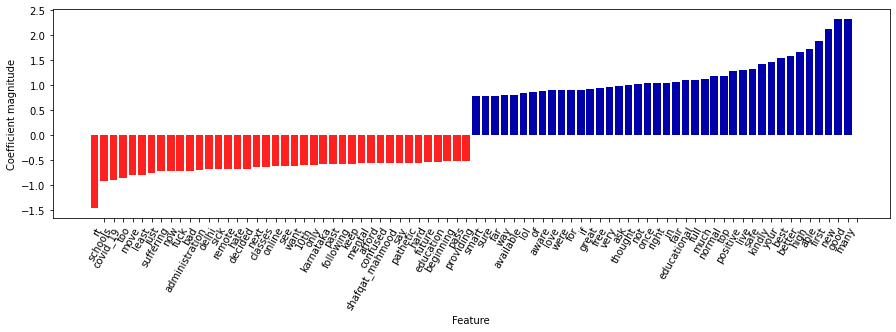

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5),
                     LogisticRegression())
pipe.fit(tweetDF["Text"], tweetDF["SentimentB"])
mglearn.tools.visualize_coefficients(
    pipe[1].coef_[0],
    pipe[0].get_feature_names(), n_top_features=40)
mglearn.tools.visualize_coefficients(
    pipe[1].coef_[1],
    pipe[0].get_feature_names(), n_top_features=40)
mglearn.tools.visualize_coefficients(
    pipe[1].coef_[2],
    pipe[0].get_feature_names(), n_top_features=40)

there are more positive than negative tweets that corrispond to the keyword covid